In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data paths
train_dir = '/content/drive/MyDrive/CRAFT-ORC-ID/textW-images/box_train'
test_dir = '/content/drive/MyDrive/CRAFT-ORC-ID/textW-images/box_test'

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Image size
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Important for text!
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator (uses 80% of training data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Key parameter
    shuffle=True
)

# Validation generator (uses 20% of training data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"\nSuccess! Found {num_classes} classes: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print("Class mapping:", train_generator.class_indices)

Found 4551 images belonging to 2 classes.
Found 1136 images belonging to 2 classes.
Found 1725 images belonging to 2 classes.

Success! Found 2 classes: ['Arabic', 'English']
Training samples: 4551
Validation samples: 1136
Test samples: 1725
Class mapping: {'Arabic': 0, 'English': 1}


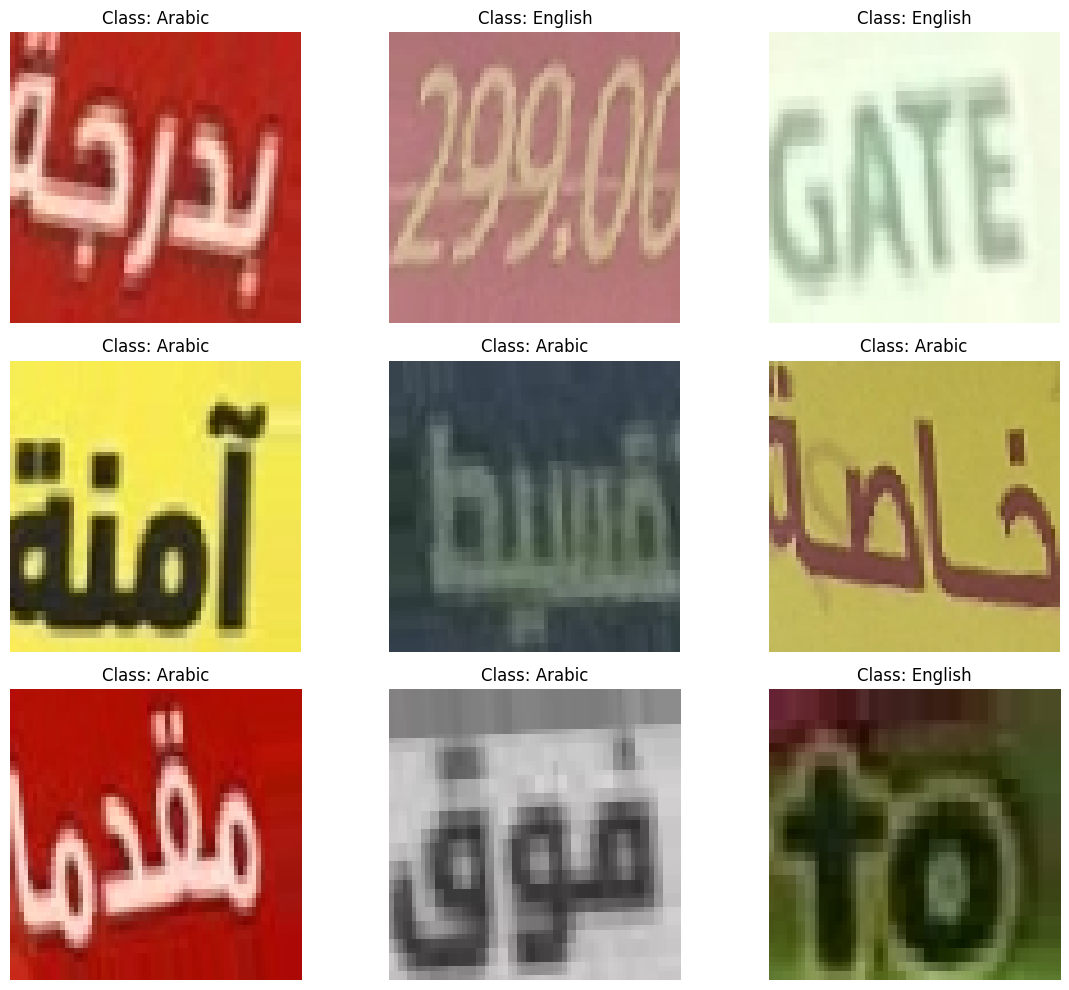

In [ ]:
# Get a batch of data
sample_images, sample_labels = next(train_generator)

# Plot the images
plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label_index = np.argmax(sample_labels[i])
    true_label = class_names[true_label_index]
    plt.title(f"Class: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential(name="Arabic_English_Classifier")

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'contrast_range'

In [ ]:
# Callbacks to prevent overfitting and improve training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
print("Training finished!")

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1371s 10s/step - accuracy: 0.6022 - loss: 0.9283 - val_accuracy: 0.7812 - val_loss: 2.8957 - learning_rate: 0.0010
Epoch 2/30
  1/142 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7812 - loss: 0.4525

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7812 - loss: 0.4525 - val_accuracy: 0.7812 - val_loss: 2.8569 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.7728 - loss: 0.5320 - val_accuracy: 0.7821 - val_loss: 0.4572 - learning_rate: 0.0010
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9062 - loss: 0.3103 - val_accuracy: 0.7830 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.8225 - loss: 0.4059 - val_accuracy: 0.7821 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9062 - loss: 0.2454 - val_accuracy: 0.7920 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - accuracy: 0.8446 - loss: 0.3558 - val_accuracy: 0.8920 - val_loss: 0.2589 - learning_rate: 0.0010
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9375 - loss: 0.1922 

In [ ]:
# Save the entire model to a single HDF5 file (.h5)
model_save_path = '/content/drive/MyDrive/arabic_english_classifier.h5'
model.save(model_save_path)
print(f" Model successfully saved to:\n{model_save_path}")

✅ Model successfully saved to:
/content/drive/MyDrive/arabic_english_classifier.h5
